## 1: First we import the required modules

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import time  
import copy
from torch.autograd import Variable
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from torchviz import make_dot
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
from model import Actor, Critic
import matplotlib.pyplot as plt
%matplotlib inline

## 2: Before you run the next cell make sure you have done the following:
- Downloaded the required environment for your operating system. Details in README.MD
- Extracted the enviroment and placed folder into same directory as results.ipynb
- Change the arg: "file_name" below to the correct environment path if required. 

The following cell initiates the Unity environment 

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis-V20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 3:Now we create the brain to interact with the environment

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 4: Next cell provides a simple example of the environment and prints out the following:
- Number of Agents(brains), 
- The number of actions 4(forwards, backward, left, right) 
- The State as a vector
- the length of the State vector

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 5: We now import the Agent and assign it a variable

There are three implementation that can be called with the arg:network
- "dqn" = Vanilla DQN
- "double" = Double DQN
- "duel" = Dueling DDQN


The Hyperparamters for all Agents variations have been set to the following. I played with the hyperparamters and trainined endless versions but decied these worked the best. If getting to the score of 13 was the most important than increasing the TAU, LR or eps_decay increased the traninig speeds but did not reach as high scores. A score of 13 could be achieved in as little as 122 episodes but this varied massivly between each training. The below achieved very consistant scores that trained fast and achieved a final score of 17 or more. 

    ```
	BUFFER_SIZE = 100000  # replay buffer size
    BATCH_SIZE = 64         # minibatch size
    GAMMA = 0.99            # discount factor
    TAU = 0.01              # for soft update of target parameters
    LR = 0.0005              # learning rate 
    UPDATE_EVERY = 4        # how often to update the network
    
    eps_start=1.0           #Initital epsilon for Epsilon greedy Action
    eps_end=0.01            #Minimun Epsilon 
    eps_decay=0.95          #Epsilon decay rate
	```




In [5]:
from agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

## 6: Lets take a look at the base DQN model
- The model  has 3 fully connected layers with 64 nodes each. 
- It takes an input of 37 (state vector) and output of 4 (action space)
- Rulu activation between layers 
- Adam optermizer.

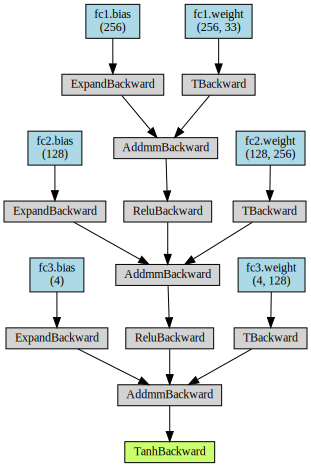

In [6]:
model = Actor(state_size, action_size, 42)
x = Variable(torch.randn(1,state_size))
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

## 7: Lets take a look at the Dueling DDQN model
- The model  has 3 fully connected layers with 64 nodes each. 
- It takes an input of 37 (state vector) and output of 4 (action space)
- Third layer is split into a Advantage and Value fully connected layer
- The advantage layer outputs 4 (number of actions)
- the Value layer outputs 1
- The final output is caluculated by Q(s,a)=V(s)+(A(s,a)-avg_a(A(s,a)))
- Rulu activation is used between layers 
- Adam optermizer.

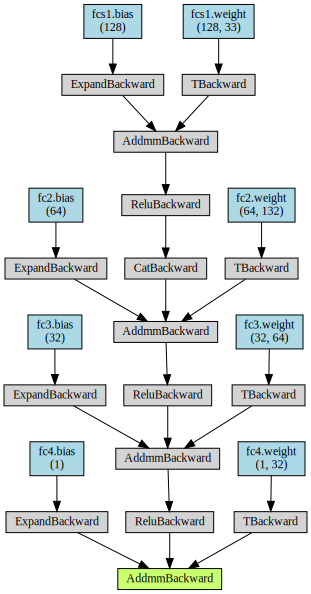

In [7]:
model = Critic(state_size, action_size, 42)
x = Variable(torch.randn(1,state_size))
z = Variable(torch.randn(1,action_size))
y = model(x, z)
             
make_dot(y, params=dict(list(model.named_parameters())))

When finished, you can close the environment.

## 8: Run the Deep Q-Learning algorithm and training steps:

The folloing cell provides the main training function. I have changed the required score for solving the environment from 13 to 17 for a little bit more of a challenge.


In [8]:
def ddpg(n_episodes=2000, max_steps=1000):
    scores_mean = deque(maxlen=100)
    scores = []
    best_score = 0
    best_average_score = 0
    for i_episode in range(1, n_episodes+1):
        average_score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        score = 0
        agent.reset()
        for step in range(max_steps):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done                  
            agent.step(states, actions, rewards, next_states, dones, step)
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break
        score = np.mean(scores_agents)
        scores_mean.append(score)
        average_score = np.mean(scores_mean)
        scores.append(score)
        if score > best_score:
            best_score = score
        if average_score > best_average_score:
            best_average_score = average_score
        print("Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Score:{:.2f}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(i_episode, scores_agents.min(), scores_agents.max(), score, best_score, average_score, best_average_score))
        if average_score > 30:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print("Average score of 30 achieved")            
            break
    return scores

scores = ddpg()

/home/adaptation/Documents/DDPG-Continuous-Control/agent.py:113: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode:1, Low Score:0.00, High Score:1.39, Score:0.58, Best Score:0.58, Average Score:0.58, Best Avg Score:0.58
Episode:2, Low Score:0.00, High Score:0.85, Score:0.37, Best Score:0.58, Average Score:0.48, Best Avg Score:0.58
Episode:3, Low Score:0.00, High Score:0.94, Score:0.44, Best Score:0.58, Average Score:0.46, Best Avg Score:0.58
Episode:4, Low Score:0.00, High Score:0.64, Score:0.30, Best Score:0.58, Average Score:0.42, Best Avg Score:0.58
Episode:5, Low Score:0.07, High Score:1.43, Score:0.54, Best Score:0.58, Average Score:0.45, Best Avg Score:0.58
Episode:6, Low Score:0.14, High Score:1.25, Score:0.63, Best Score:0.63, Average Score:0.48, Best Avg Score:0.58
Episode:7, Low Score:0.05, High Score:2.46, Score:0.77, Best Score:0.77, Average Score:0.52, Best Avg Score:0.58
Episode:8, Low Score:0.40, High Score:1.76, Score:0.86, Best Score:0.86, Average Score:0.56, Best Avg Score:0.58
Episode:9, Low Score:0.17, High Score:3.29, Score:1.14, Best Score:1.14, Average Score:0.63, Bes

Episode:72, Low Score:11.63, High Score:32.55, Score:22.26, Best Score:22.26, Average Score:11.93, Best Avg Score:11.93
Episode:73, Low Score:11.32, High Score:32.46, Score:20.51, Best Score:22.26, Average Score:12.05, Best Avg Score:12.05
Episode:74, Low Score:13.90, High Score:27.64, Score:19.20, Best Score:22.26, Average Score:12.14, Best Avg Score:12.14
Episode:75, Low Score:14.31, High Score:26.14, Score:19.52, Best Score:22.26, Average Score:12.24, Best Avg Score:12.24
Episode:76, Low Score:14.87, High Score:33.95, Score:20.73, Best Score:22.26, Average Score:12.35, Best Avg Score:12.35
Episode:77, Low Score:11.93, High Score:34.62, Score:22.05, Best Score:22.26, Average Score:12.48, Best Avg Score:12.48
Episode:78, Low Score:17.36, High Score:34.40, Score:22.85, Best Score:22.85, Average Score:12.61, Best Avg Score:12.61
Episode:79, Low Score:16.51, High Score:30.27, Score:21.52, Best Score:22.85, Average Score:12.73, Best Avg Score:12.73
Episode:80, Low Score:16.16, High Score:

Episode:140, Low Score:31.78, High Score:39.39, Score:35.98, Best Score:35.98, Average Score:25.62, Best Avg Score:25.62
Episode:141, Low Score:30.43, High Score:38.66, Score:34.90, Best Score:35.98, Average Score:25.82, Best Avg Score:25.82
Episode:142, Low Score:26.61, High Score:38.83, Score:34.49, Best Score:35.98, Average Score:26.01, Best Avg Score:26.01
Episode:143, Low Score:33.04, High Score:38.90, Score:35.97, Best Score:35.98, Average Score:26.21, Best Avg Score:26.21
Episode:144, Low Score:31.22, High Score:38.95, Score:35.73, Best Score:35.98, Average Score:26.41, Best Avg Score:26.41
Episode:145, Low Score:28.93, High Score:39.53, Score:36.76, Best Score:36.76, Average Score:26.62, Best Avg Score:26.62
Episode:146, Low Score:31.01, High Score:39.38, Score:35.77, Best Score:36.76, Average Score:26.81, Best Avg Score:26.81
Episode:147, Low Score:32.71, High Score:39.32, Score:36.31, Best Score:36.76, Average Score:27.01, Best Avg Score:27.01
Episode:148, Low Score:28.33, Hi

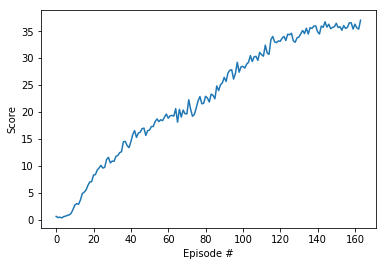

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 9 Load the saved weights for the network

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

## 10: Now sit back and watch the MASTER trained network collect Bannanas.

In [ ]:
# watch the Master agent
def ddpg(n_episodes=1, max_steps=1000):
    scores_hundred_queue = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        agent.reset()
        score = 0
        for step in range(max_steps):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done                  
            agent.step(states, actions, rewards, next_states, dones, step)
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break
        score = np.mean(scores_agents)
        scores.append(score)        
        print("Episode: ", i_episode)
        print("Score: {:.2f}".format(score))
    
       
        
      
    return scores

scores = ddpg()

In [ ]:
env.close()